In [1]:
# intsall the following dependcies
# %pip install pmdarima
# %pip install chart_studio
# %pip install statsmodels
# %pip install matplotlib
# %pip install cufflinks
# %pip install seaborn
import plotly
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import chart_studio

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import chart_studio.plotly as py
from chart_studio.plotly import plot, iplot
import cufflinks as cf
import seaborn as sns
import plotly.express as px

import plotly.graph_objs as go
from pmdarima import auto_arima

chart_studio.tools.set_credentials_file(username='shhreyaa',                                              
                                  api_key='UGJfLKcZ6nznR80PcPL8')

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Use Plotly locally
cf.go_offline()

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel("sales_replaced.xlsx")
# df  = pd.read_excel("sales_11.xlsx")
df['Order Date'] = pd.to_datetime(df['Order Date'])


df.info()
df1= df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Row ID        9994 non-null   int64         
 1   Order Date    9994 non-null   datetime64[ns]
 2   Customer ID   9994 non-null   object        
 3   Segment       9994 non-null   object        
 4   Product ID    9994 non-null   object        
 5   Category      9994 non-null   object        
 6   Sub-Category  9994 non-null   object        
 7   Product Name  9994 non-null   object        
 8   Sales         9994 non-null   float64       
 9   Quantity      9994 non-null   int64         
 10  Discount      9994 non-null   float64       
 11  Profit        9994 non-null   float64       
 12  month         9994 non-null   object        
 13  year          9994 non-null   int64         
 14  Unnamed: 14   0 non-null      float64       
dtypes: datetime64[ns](1), float64(4), int6

In [3]:
#Exploratory Data Analysis
#sales and profit of total sales



cols = ['Row ID','Customer ID', 'Segment','Category', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount']
df1.drop(cols, axis=1, inplace=True)
factors = ['Sales','Profit']


df1 = df1.sort_values('Order Date')
df1.isnull().sum()

trace_list = []

df1= df.set_index('Order Date').resample('MS').sum()
length = 2
colors=[]

for y in range(length):

    trace = go.Scatter(
        y=df1[factors[y]],
        x=df1.index,
        mode='lines',
        name=factors[y],

        line = dict(
#                     color = colors[y],
                    width = 2,
#                    dash = 'dot'
                    )
        )
    trace_list.append(trace)
layout = go.Layout(
    xaxis=dict(title='Year from 2014 to 2018', zeroline=False, rangeslider=dict(visible=True)),
    yaxis=dict(title='Sales', zeroline=False),

    title='Sales vs Profit',
    showlegend=True,
    )
fig = go.Figure(data=trace_list, layout=layout)
py.iplot(fig,sharing='public')



In [4]:
def profit(prof):
      x= prof
      prof = df.loc[df['Category'] == "{}".format(prof)]
    
    
      cols = ['Row ID','Sales','Customer ID', 'Segment','Product ID', 'Category','Sub-Category', 'Product Name', 'Quantity', 'Discount']
      prof.drop(cols, axis=1, inplace=True)
      prof = prof.sort_values('Order Date')
      prof.isnull().sum()
      prof = prof.set_index('Order Date')

      y_fur = prof['Profit'].resample('MS').sum()
      y_fur.plot(figsize=(15, 6))
      plt.plot()
      plt.xlabel('Time')
      plt.ylabel('Profit in Rs')
      plt.legend(["{}".format(x)])
        

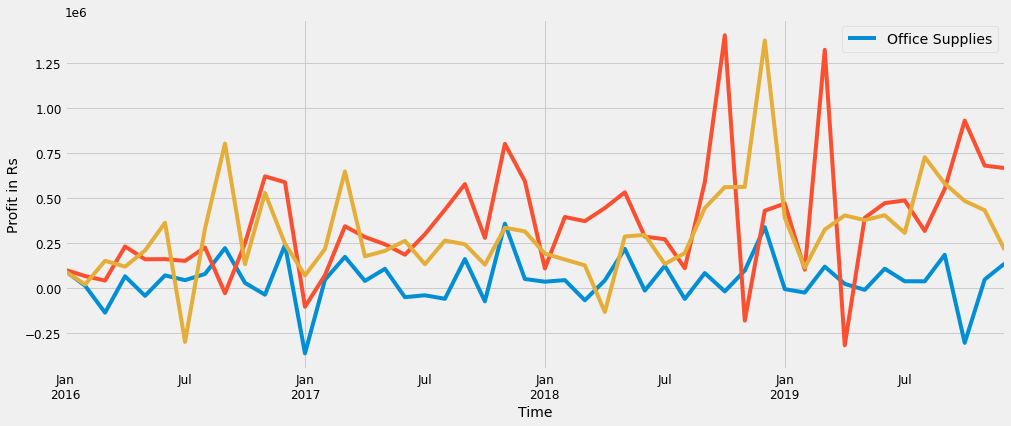

In [5]:
profit('Furniture')

profit('Technology')
profit('Office Supplies')

In [6]:
#Function to predict the forcast
def sales(sale_category):
    x= sale_category

    # sale_category = df.loc[df['Category'] == sale_category]
    sale_category = df.loc[df["Category"] == "{}".format(x)]
    cols = ['Row ID', 'Customer ID', 'Segment', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
    sale_category.drop(cols, axis=1, inplace=True)
    sale_category = sale_category.sort_values('Order Date')

    sale_category.isnull().sum()
    sale_category= sale_category.groupby('Order Date')['Sales'].sum().reset_index()
    sale_category = sale_category.set_index('Order Date')
    sale_category=sale_category['Sales'].resample('MS').sum()
  
    #checking if we can fit arima model by decomposing the graph
   
    decompose(sale_category)
   

    sale_category.head(100)
    train = sale_category[:'2019-01-01']
    train.head()
    test= sale_category['2019-01-01':]

    # train = sale_total[:'2017-01-01']
    # train.head()
    # test= sale_total['2017-01-01':]
    plt.plot(train)
    plt.plot(test)


    stepwise_model = auto_arima(sale_category, start_p=0,start_q=0,
       max_p=2,max_d=2, max_q=2, m=12,
       start_P=0,start_Q=0, seasonal=True,
       d=0, D=1, trace=True,
       error_action='ignore',  
       suppress_warnings=True, 
       stepwise=True)
    print(stepwise_model.aic())
    print(stepwise_model.summary())

    stepwise_model.fit(train)
    future_forecast = stepwise_model.predict(n_periods=12)
    
    # This returns an array of predictions:
   
    future_forecast = pd.DataFrame(future_forecast,index = test.index,columns =
           ["Prediction"])
    pd.concat([test,future_forecast],axis=1).iplot()
    pd.concat([sale_category,future_forecast],axis=1).iplot()
    future_forecast2 = stepwise_model.predict(n_periods=30)
    #     This returns an array of predictions:
    
    index = pd.date_range('2019-12-01', periods=30, freq='M')
    future_forecast2 = pd.DataFrame(future_forecast2,index =index,columns =
           ["Prediction"])
    pd.concat([sale_category,future_forecast2],axis=1).iplot()
  

In [7]:
def decompose(y):
    from pylab import rcParams
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    fig = decomposition.plot()
    plt.show()

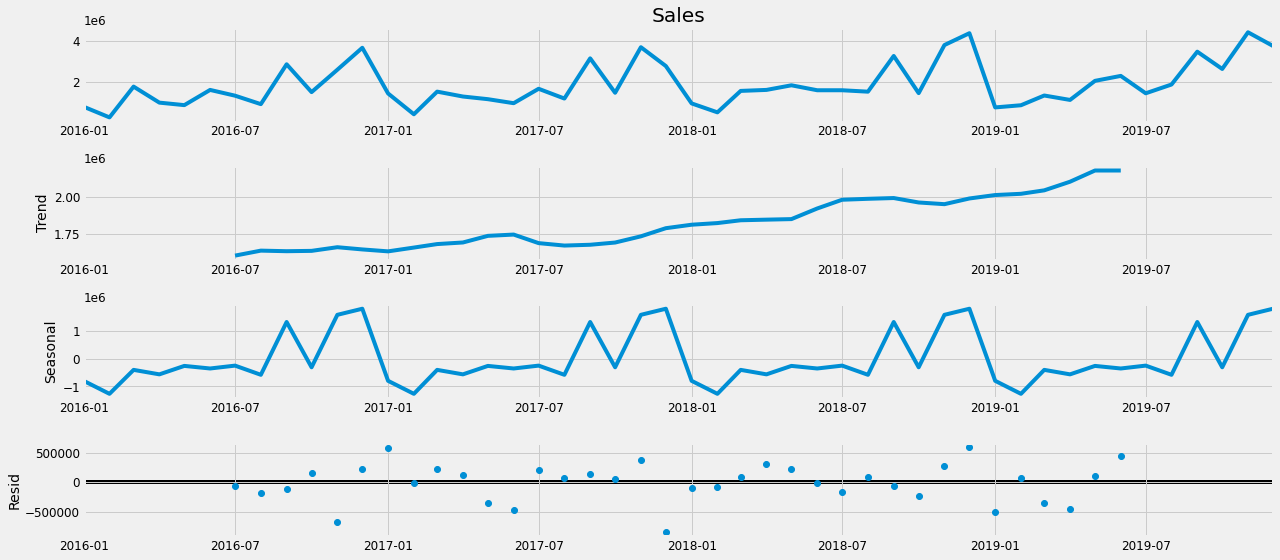

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1053.496, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1054.079, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1054.515, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1057.867, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1052.757, Time=0.03 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1052.509, Time=0.11 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=1054.506, Time=0.15 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1054.624, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1054.326, Time=0.10 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1054.727, Time=0.10 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1056.718, Time=0.19 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=1053.412, Time=0.05 sec

Best model:  ARIMA(0,0,0)(2,1,0)[12] intercept
Total fit time: 0.953 seconds
1052.5087247176295
                                SARIMAX Results         

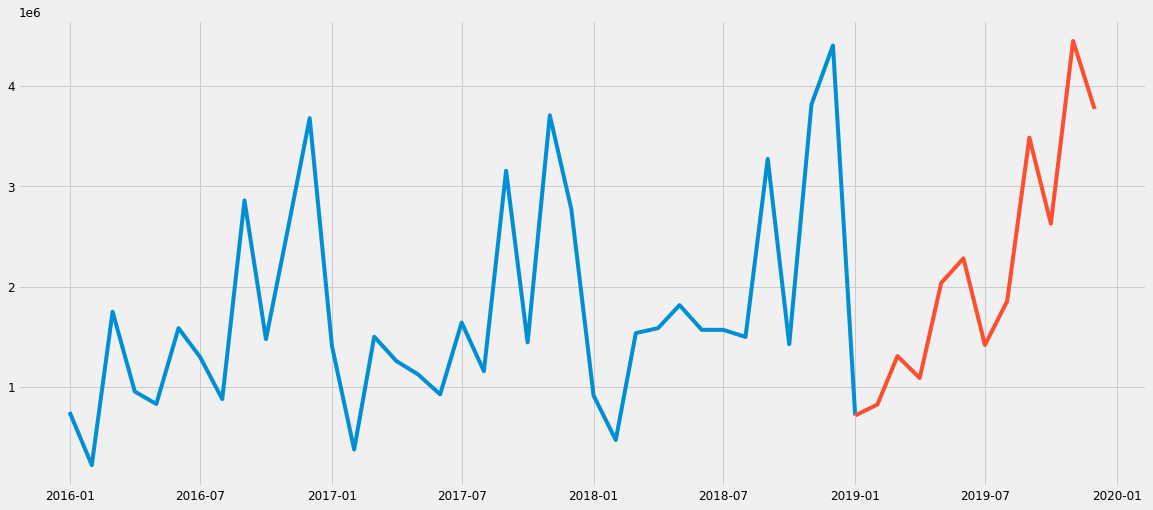

In [8]:
sales("Furniture")

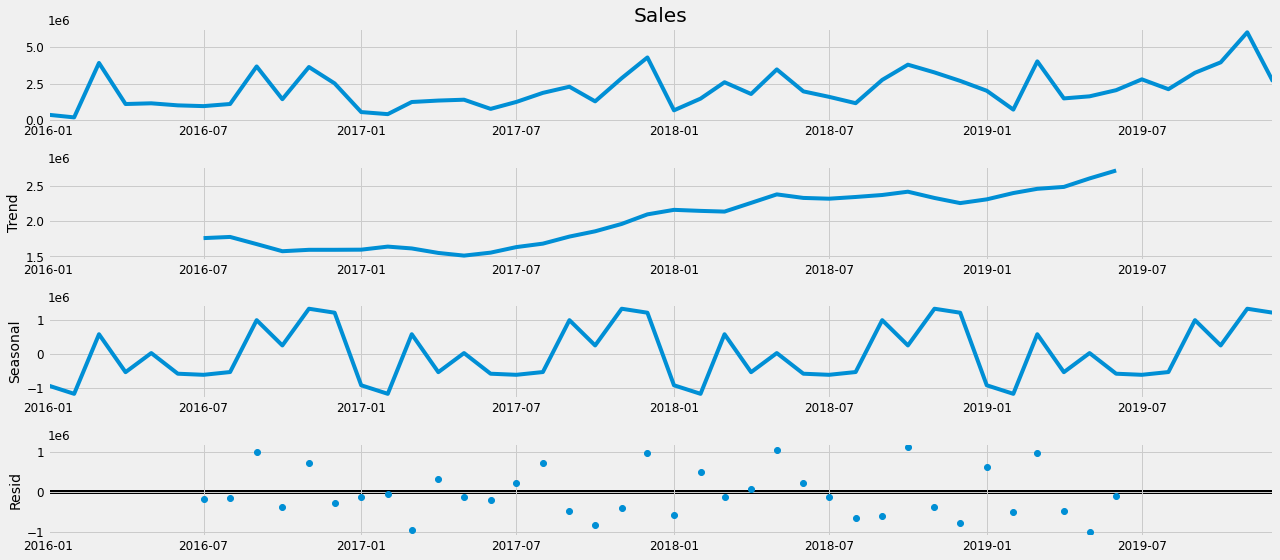

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1110.008, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1106.181, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1099.965, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1112.430, Time=0.00 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1112.553, Time=0.07 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1101.930, Time=0.22 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1101.055, Time=0.34 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1103.437, Time=0.08 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1102.143, Time=0.34 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1101.657, Time=0.03 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1100.771, Time=0.07 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1101.077, Time=0.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1103.202, Time=0.08 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1102.046, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1

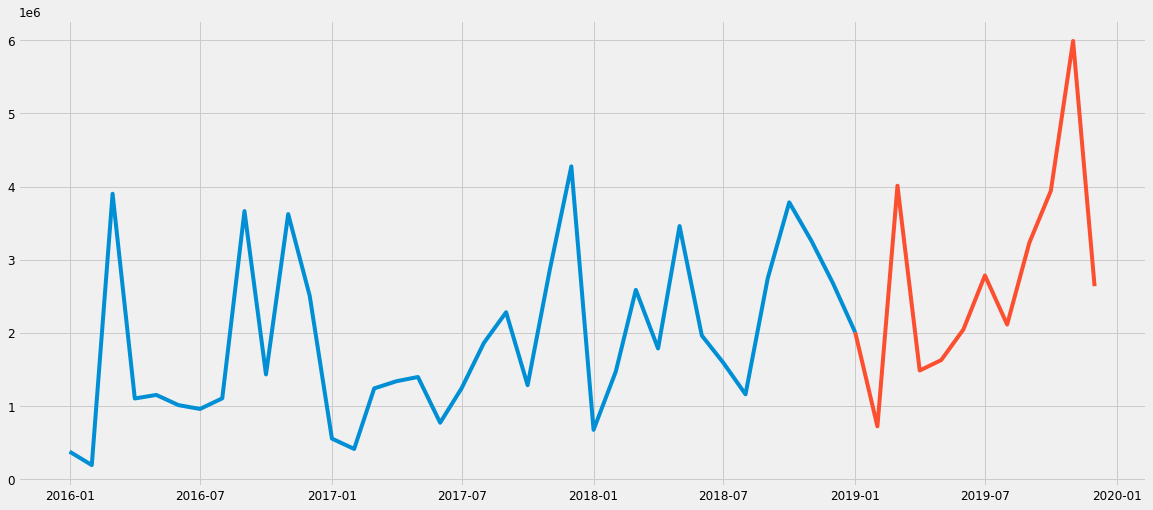

In [9]:
sales("Technology")

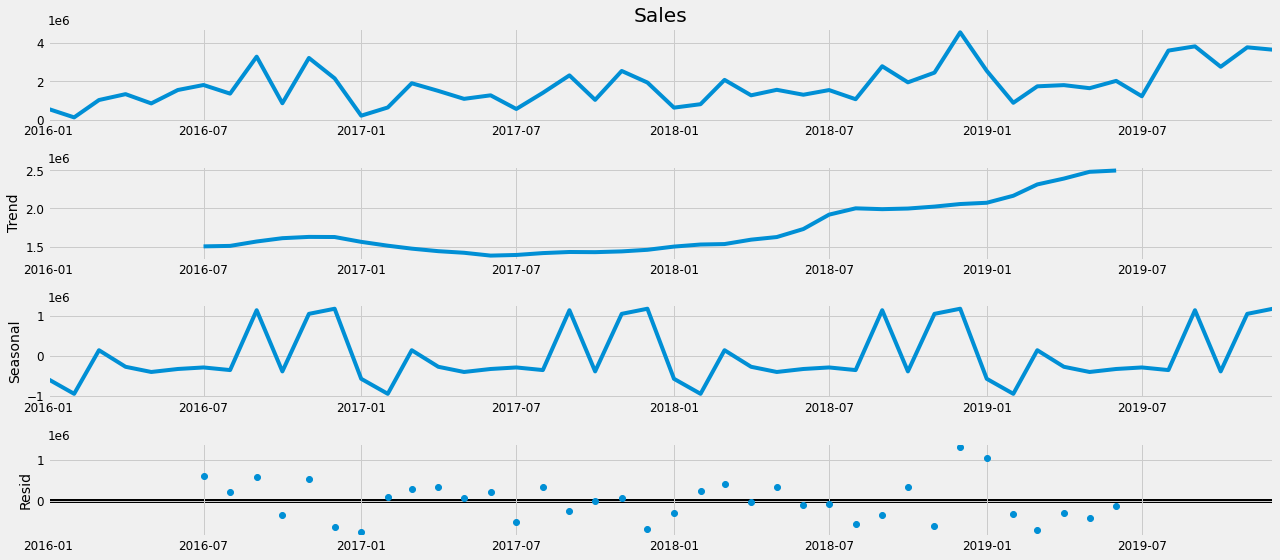

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1088.769, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1083.074, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1083.283, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1093.079, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1090.550, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1084.673, Time=0.13 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1083.074, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1081.088, Time=0.06 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1082.102, Time=0.16 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1083.199, Time=0.19 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1080.338, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1082.046, Time=0.07 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1080.868, Time=0.11 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1082.323, Time=0.07 sec
 ARIMA(0,0,0)(1,1,2

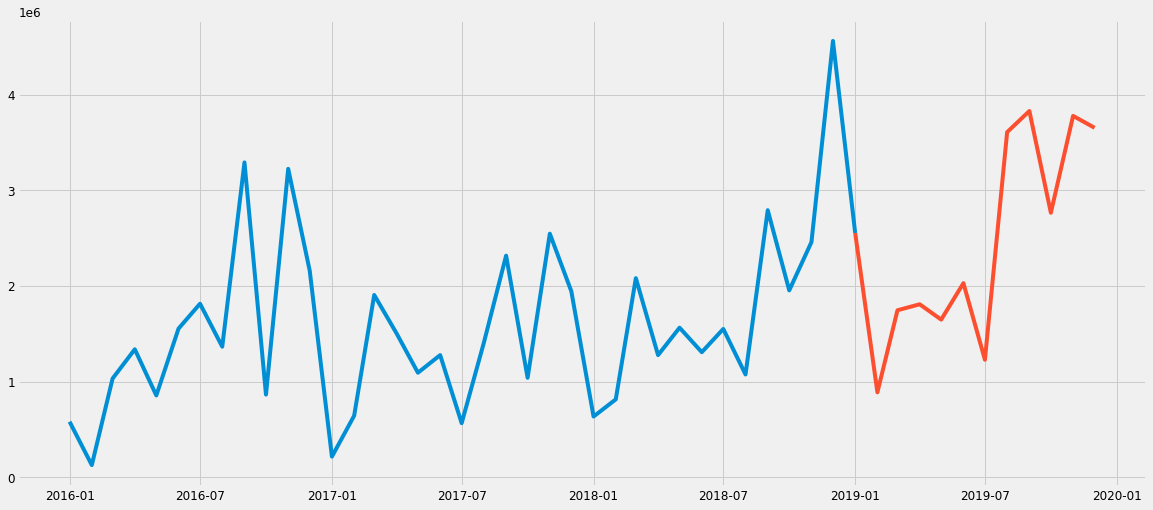

In [10]:
sales("Office Supplies")

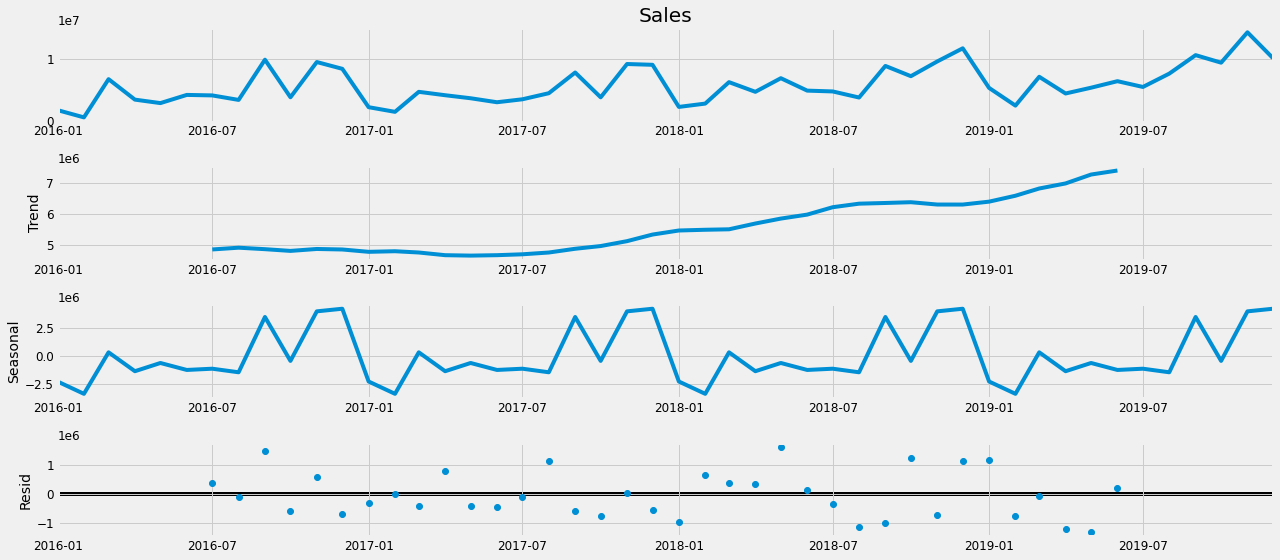

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1134.544, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1131.309, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1128.995, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1142.802, Time=0.00 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1136.687, Time=0.02 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1130.770, Time=0.13 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1129.775, Time=0.10 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1130.248, Time=0.04 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1130.943, Time=0.24 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1128.145, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1129.504, Time=0.07 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1128.477, Time=0.09 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1129.334, Time=0.05 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=1128.824, Time=0.13 sec
 ARIMA(1,0,0)(0,1,1

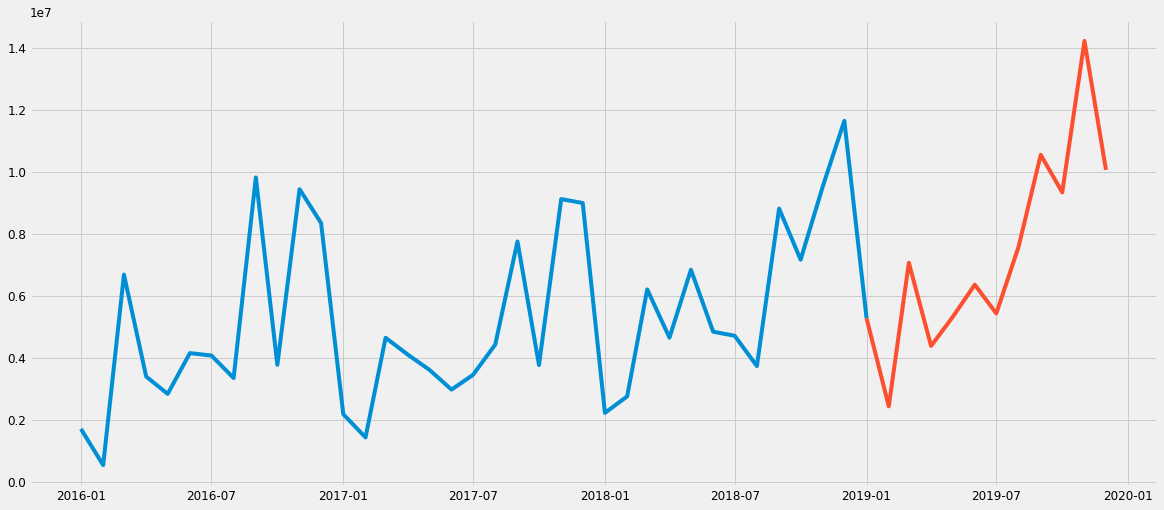

In [11]:
sale_total = pd.read_excel("sales_replaced.xlsx")
sale_total.head()
cols = ['Row ID', 'Customer ID', 'Segment', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
sale_total.drop(cols, axis=1, inplace=True)
sale_total = sale_total.sort_values('Order Date')


sale_total.isnull().sum()
sale_total= sale_total.groupby('Order Date')['Sales'].sum().reset_index()
sale_total = sale_total.set_index('Order Date')

sale_total=sale_total['Sales'].resample('MS').sum()
decompose(sale_total)
sale_total= sale_total.to_frame()






train = sale_total[:'2019-01-01']
train.head()
test= sale_total['2019-01-01':]

# train = sale_total[:'2017-01-01']
# train.head()
# test= sale_total['2017-01-01':]
plt.plot(train)
plt.plot(test)


# print(sale_total['Order Date'])
stepwise_model = auto_arima(sale_total, start_p=0,start_q=0,
                           max_p=2,max_d=2, max_q=2, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
stepwise_model.summary()
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=12)
# This returns an array of predictions:

future_forecast = stepwise_model.predict(n_periods=12)
# This returns an array of predictions:

future_forecast = pd.DataFrame(future_forecast,index = test.index,columns =
                               ["Prediction"])
pd.concat([test,future_forecast],axis=1).iplot()
pd.concat([sale_total,future_forecast],axis=1).iplot()

In [12]:
#To expiort it into excel sheet for data visualization
# from openpyxl.workbook import Workbook
# future_forecast2 = stepwise_model.predict(n_periods=30)
# # This returns an array of predictions:
# print(future_forecast2)
# index = pd.date_range('2019-12-01', periods=30, freq='M')
# future_forecast2 = pd.DataFrame(future_forecast2,index =index,columns =
#                                ["Prediction"])
# pd.concat([sale_total,future_forecast2],axis=1).iplot()

# future_forecast2['Date']= index

# # write DataFrame to excel 
# datatoexcel = pd.ExcelWriter('future_replaced_forecast.xlsx') 

# future_forecast2.to_excel(datatoexcel) 
  
# # save the excel 
# datatoexcel.save() 
# print('DataFrame is written to Excel File successfully.')

# future_forecast2.to_excel('future_replaced_forecast.xlsx', index=False)
